In [2]:
import boto3
import json
import datetime
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

CANSERVER_PARSED_BUCKET = 'matt3r-canserver-us-west-2'
CANSERVER_EVENT_BUCKET = 'matt3r-canserver-event-us-west-2'
IMU_BUCKET = 'matt3r-imu-us-west-2'
s3_client = boto3.client('s3')

In [13]:
start_date_str = '2023-05-29'
end_date_str = '2023-05-29'
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

time gap before processing: 36537.95586037636
time gap after processing: 281.02365159988403


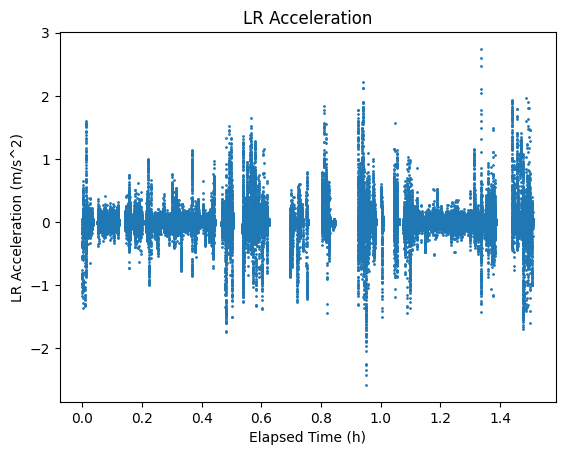

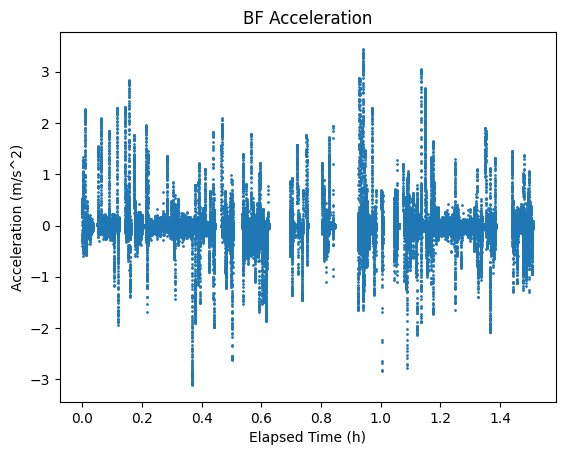

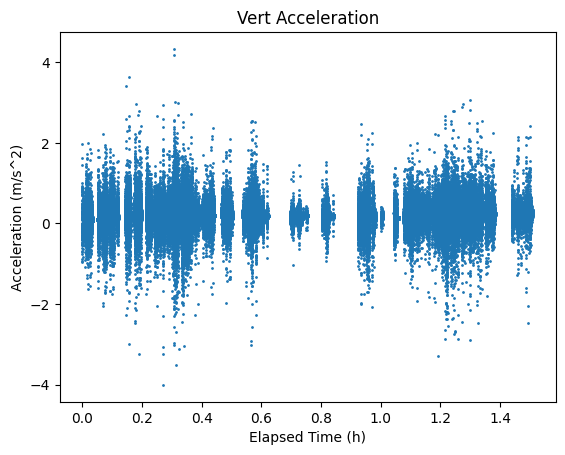

In [23]:
# getting the parquet files from the IMU bucket

# get a list of all parquet files in the prefix and filter them to within the date range
# response = s3_client.list_objects(Bucket=IMU_BUCKET, Prefix="hamid/k3y-78f8031e/accel/")
response = s3_client.list_objects(Bucket=IMU_BUCKET, Prefix="mohsen/k3y-7724670b/accel/")
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and file.split('/')[-1].split('_')[0] != 'raw'
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(df)
df = pd.concat(df_list, axis=0, ignore_index=True)

# drop any nan values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# process any gaps in the data so it has the correct start time
stale_time = 6000
max_jump = df['timestamp(epoch in sec)'].diff().max()
print(f'time gap before processing: {max_jump}')
while(max_jump > stale_time):
    time_jump_index = df['timestamp(epoch in sec)'].diff().argmax()
    df = df.iloc[time_jump_index :].reset_index(drop=True)
    max_jump = df['timestamp(epoch in sec)'].diff().max()
print(f'time gap after processing: {max_jump}')

df['elapsed_time'] = (df['timestamp(epoch in sec)'] - df['timestamp(epoch in sec)'].min())/3600

fig, ax = plt.subplots()
ax.scatter(x=df['elapsed_time'], y=df['lr_acc(m/s^2)'], s=1)
plt.title(f'LR Acceleration', wrap = True)
plt.xlabel('Elapsed Time (h)')
plt.ylabel('LR Acceleration (m/s^2)')

plt.show()

fig, ax = plt.subplots()
ax.scatter(x=df['elapsed_time'], y=df['bf_acc(m/s^2)'], s=1)
plt.title(f'BF Acceleration', wrap = True)
plt.xlabel('Elapsed Time (h)')
plt.ylabel('Acceleration (m/s^2)')

plt.show()

fig, ax = plt.subplots()
ax.scatter(x=df['elapsed_time'], y=df['vert_acc(m/s^2)'], s=1)
plt.title(f'Vert Acceleration', wrap = True)
plt.xlabel('Elapsed Time (h)')
plt.ylabel('Acceleration (m/s^2)')

plt.show()

In [22]:
# testing to see what gets written to infer
df_infer = pd.read_parquet('/home/tyler/Documents/Matt3r/IMU_validation/2023-05-19.parquet')
print(df_infer[:3])

Empty DataFrame
Columns: [timestamp(epoch in sec), harsh_break(value), harsh_forward_acc(value)]
Index: []


Rotation Matrix Computation

In [1]:
import numpy as np
from ahrs.filters import Madgwick
from scipy import signal
from scipy.spatial.transform import Rotation as R

In [9]:
rot_mtxs = R.from_quat(np.roll(np.array([0,0,0,1]), shift=3)).as_matrix()[np.newaxis, :]
print(rot_mtxs)
print(rot_mtxs[:,-1,:])

[[[-1.  0.  0.]
  [ 0. -1.  0.]
  [ 0.  0.  1.]]]
[[0. 0. 1.]]


In [8]:
def rotateAlign(v1, v2):
    axis = np.cross(v1, v2)
    cosA = np.dot(v1, v2)
    k = 1 / (1 + cosA)
    result = np.array( [[(axis[0] * axis[0] * k) + cosA,
            (axis[1] * axis[0] * k) - axis[2], 
            (axis[2] * axis[0] * k) + axis[1]],
            [(axis[0] * axis[1] * k) + axis[2],  
            (axis[1] * axis[1] * k) + cosA,      
            (axis[2] * axis[1] * k) - axis[0]],
            [(axis[0] * axis[2] * k) - axis[1],  
            (axis[1] * axis[2] * k) + axis[0],  
            (axis[2] * axis[2] * k) + cosA]])
    return result

v1 = np.array([9.9,-0.16,-0.44])
v2 = np.array([0,0,1])

rotateAlign(v1,v2)

array([[-3.94285714e-01,  2.82857143e+00, -9.90000000e+00],
       [ 2.82857143e+00,  1.74577857e+02,  1.60000000e-01],
       [ 9.90000000e+00, -1.60000000e-01, -4.40000000e-01]])

In [ ]:
def getRotMatrix(acc):
    acc_dir = acc/np.linalg.norm(acc)
    return rotateAlign(acc_dir,np.array([0,0,-1]))

acc = np.array([0.2,0.1,-9.81])
getRotMatrix(acc)

In [7]:
def getRotMatrix(acc):
    acc_dir = acc/np.linalg.norm(acc)
    return rotateAlign(acc_dir,np.array([0,0,-1]))

acc = np.array([0.2,0.1,-9.81])
getRotMatrix(acc)


array([[ 9.99792259e-01, -1.03870637e-04,  2.03820657e-02],
       [-1.03870637e-04,  9.99948065e-01,  1.01910329e-02],
       [-2.03820657e-02, -1.01910329e-02,  9.99740323e-01]])

Method that computes the k3y to car rotation matrix

In [12]:
import boto3
import json
import datetime
import numpy as np
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt

CANSERVER_EVENT_BUCKET = 'matt3r-canserver-event-us-west-2'
IMU_BUCKET = 'matt3r-imu-us-west-2'
s3_client = boto3.client('s3')

In [14]:
# define variables

start_date_str = '2023-05-31'
end_date_str = '2023-05-31'
organization_id = 'hamid'
can_k3y_id = '9ed5b50e'
imu_k3y_id = '78f8031e'

start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

# retrieve the event data

# get a list of all json files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=CANSERVER_EVENT_BUCKET, Prefix=organization_id + '/' + 'k3y-' + can_k3y_id + '/')
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'json'
        and len(file.split('/')[-1]) == 15
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered json files
event_dict = {}
for key in keys:
    response = s3_client.get_object(Bucket=CANSERVER_EVENT_BUCKET, Key=key)
    result = json.loads(response["Body"].read().decode())
    for index in result['imu_telematics']:
        if index in event_dict:
            event_dict[index].extend(result['imu_telematics'][index])
        else:
            event_dict[index] = result['imu_telematics'][index]

# Retrieve the raw IMU data

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=IMU_BUCKET, Prefix=organization_id + '/' + 'k3y-' + imu_k3y_id + '/accel/')
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and len(file.split('/')[-1].split('_')[1]) == 10
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[1], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[1], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    imu_df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(imu_df)
imu_df = pd.concat(df_list, axis=0, ignore_index=True)

# defining the rotation matrix function

def getRotMatrix(acc):
    acc_dir = acc/np.linalg.norm(acc)
    k = 1 / (1 - acc_dir[2])
    result = np.array([[acc_dir[1]**2 * k - acc_dir[2], -acc_dir[0] * acc_dir[1] * k, acc_dir[0]],
                       [-acc_dir[0] * acc_dir[1] * k, acc_dir[0]**2 * k - acc_dir[2], acc_dir[1]],
                       [-acc_dir[0], -acc_dir[1], -acc_dir[2]]])
    return -result

In [36]:
# pulling data from the parked states
count = 0
for state_num in range(len(event_dict['parked_state'])):
    pk_start_time = event_dict['parked_state'][state_num]['timestamp'][0]
    pk_end_time = event_dict['parked_state'][state_num]['timestamp'][1]
    pk_motion = imu_df[(imu_df['timestamp(epoch in sec)'] >= pk_start_time) & (imu_df['timestamp(epoch in sec)'] <= pk_end_time)]
    if(len(pk_motion) != 0):
        acc_mean = np.array([pk_motion['lr_acc(m/s^2)'].mean(), 
                             pk_motion['bf_acc(m/s^2)'].mean(), 
                             pk_motion['vert_acc(m/s^2)'].mean()])
        print(acc_mean)
        print(len(pk_motion))
        count += 1
        if(count >= 1):
            break
rot_matrix = getRotMatrix(acc_mean)

[ 0.10056882  0.57807213 -9.869729  ]
119


In [51]:
acc_data = np.vstack((np.array(pk_motion['lr_acc(m/s^2)']),
                      np.array(pk_motion['bf_acc(m/s^2)']),
                      np.array(pk_motion['vert_acc(m/s^2)'])))
rot_acc_data = np.dot(rot_matrix, acc_data)
print(rot_acc_data[:,1])

[-5.07977065e-04 -3.26902241e-03  9.88920472e+00]


In [9]:
def getRotMatrix(acc):
    acc_dir = acc/np.linalg.norm(acc)
    k = 1 / (1 - acc_dir[2])
    result = np.array([[(acc_dir[1]**2 * k) - acc_dir[2],
                        -acc_dir[0] * acc_dir[1] * k, 
                        acc_dir[0]],
                        [-acc_dir[0] * acc_dir[1] * k,  
                        (acc_dir[0]**2 * k) - acc_dir[2],      
                        acc_dir[1]],
                        [-acc_dir[0],  
                        -acc_dir[1],  
                        -acc_dir[2]]])
    return -result

acc = np.array([0.2,0.1,-9.81])
getRotMatrix(acc)

array([[ 9.99792259e-01, -1.03870637e-04,  2.03820657e-02],
       [-1.03870637e-04,  9.99948065e-01,  1.01910329e-02],
       [-2.03820657e-02, -1.01910329e-02,  9.99740323e-01]])

In [2]:
import correct_drift
import pandas as pd

start_date_str = '2023-05-31'
end_date_str = '2023-05-31'
organization_id = 'hamid'
can_k3y_id = '9ed5b50e'
imu_k3y_id = '78f8031e'

imu_df = correct_drift.correct_imu(imu_k3y_id, organization_id, start_date_str, end_date_str)
print(imu_df)

         timestamp(epoch in sec)  lr_acc(m/s^2)  bf_acc(m/s^2)   
0                   1.685491e+09       0.013951      -0.010961  \
1                   1.685491e+09       0.016942      -0.009764   
2                   1.685491e+09       0.014549      -0.010961   
3                   1.685491e+09       0.016343      -0.006773   
4                   1.685491e+09       0.016942      -0.009764   
...                          ...            ...            ...   
2260539             1.685569e+09       0.021846       0.027751   
2260540             1.685569e+09       0.024238       0.028349   
2260541             1.685569e+09       0.027828       0.025358   
2260542             1.685569e+09       0.028426       0.028349   
2260543             1.685569e+09       0.027828       0.028947   

         vert_acc(m/s^2)  correct_timestamp  
0               0.074785       1.685491e+09  
1               0.080169       1.685491e+09  
2               0.077776       1.685491e+09  
3               0.07837

# Get Angle of Tilt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
import plot_data
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)
importlib.reload(plot_data)

<module 'plot_data' from '/home/tyler/Documents/Matt3r/IMU_validation/plot_data.py'>

In [23]:
start_date_str = '2023-05-30'
end_date_str = '2023-06-01'
organization_id = 'hamid'
can_k3y_id = '9ed5b50e'
imu_k3y_id = '78f8031e'

In [2]:
# Hamid data
start_date_str = '2023-06-28'
end_date_str = '2023-06-28'
organization_id = 'hamid'
can_k3y_id = '17700cf8'
imu_k3y_id = '17700cf8'

Get Data

In [24]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)
imu_df, gy_df = fetch_data.get_raw_data(imu_k3y_id, organization_id, start_date_str, end_date_str, time_correction=True)

Rotation Matrix for Angle

In [11]:
az = 9.835
# ay = 0.835
ay = 0.987
g = np.sqrt(az**2 + ay**2)
TILT_ROT = np.array([[1, 0, 0], [0, az/g, ay/g], [0, -ay/g, az/g]])
acc_np = imu_df[['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
vehicle_ac = np.matmul(TILT_ROT, acc_np[:, 1:].T)
vehicle_ac_np = np.column_stack((acc_np[:,0], vehicle_ac.T))
imu_df = pd.DataFrame(vehicle_ac_np, columns=['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])

In [25]:
# parked state metrics

imu_ss_states = []
for state_num in range(len(event_dict['parked_state'])):
    ss_start_time = event_dict['parked_state'][state_num]['timestamp'][0]
    ss_end_time = event_dict['parked_state'][state_num]['timestamp'][1]
    imu_ss_states.append(imu_df[(imu_df['correct_timestamp'] >= ss_start_time) 
                       & (imu_df['correct_timestamp'] <= ss_end_time)])
imu_ss_df = pd.concat(imu_ss_states, ignore_index=True)

print('left/right acceleration:')
print(f'imu mean: {imu_ss_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["lr_acc(m/s^2)"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {imu_ss_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["bf_acc(m/s^2)"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {imu_ss_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["vert_acc(m/s^2)"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(imu_ss_df['lr_acc(m/s^2)']**2 + imu_ss_df['bf_acc(m/s^2)']**2 + imu_ss_df['vert_acc(m/s^2)']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')

left/right acceleration:
imu mean: -0.19306611401846574
imu max: 1.359719965
imu min: -12.78364085

back/from acceleration:
imu mean: 1.0902880068451566
imu max: 11.431099345
imu min: -5.222927855

vertical acceleration:
imu mean: -8.540508226576
imu max: 9.739375605
imu min: -10.161708335

normalized acceleration:
imu mean: 9.871496575353511
imu max: 15.624567938249431
imu min: 4.413695336563972


In [26]:
# stationary state metrics

imu_ss_states = []
for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    imu_ss_states.append(imu_df[(imu_df['correct_timestamp'] >= ss_start_time) 
                       & (imu_df['correct_timestamp'] <= ss_end_time)])
imu_ss_df = pd.concat(imu_ss_states, ignore_index=True)

print('left/right acceleration:')
print(f'imu mean: {imu_ss_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["lr_acc(m/s^2)"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {imu_ss_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["bf_acc(m/s^2)"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {imu_ss_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["vert_acc(m/s^2)"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(imu_ss_df['lr_acc(m/s^2)']**2 + imu_ss_df['bf_acc(m/s^2)']**2 + imu_ss_df['vert_acc(m/s^2)']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')

left/right acceleration:
imu mean: 0.022011308325318304
imu max: 0.23569277
imu min: -0.499501175

back/from acceleration:
imu mean: 0.6480049497980214
imu max: 1.41654944
imu min: -0.51086707

vertical acceleration:
imu mean: -9.86401997583883
imu max: -9.7387774
imu min: -9.95532761

normalized acceleration:
imu mean: 9.888487850448296
imu max: 9.97407397778371
imu min: 9.807187288039016


Plot Data

0.0654262433330519


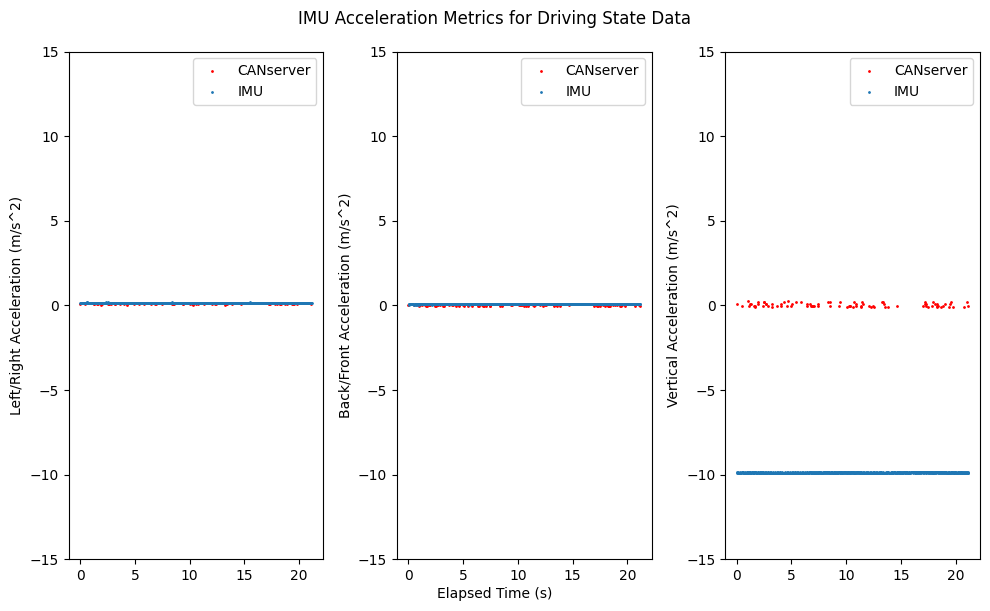

0.02093340719425407


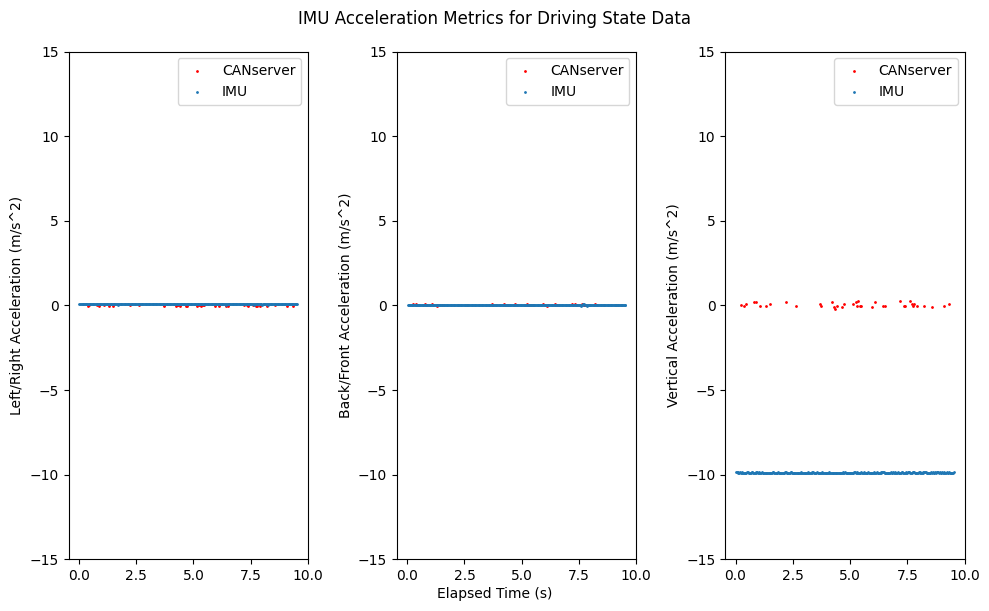

-0.06260541651279501


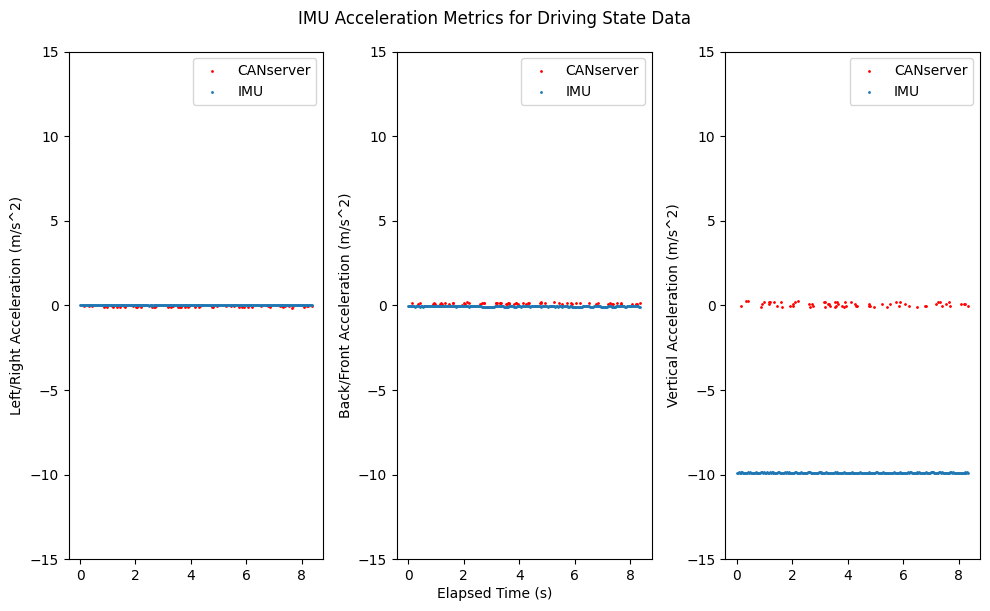

-0.016637156432691452


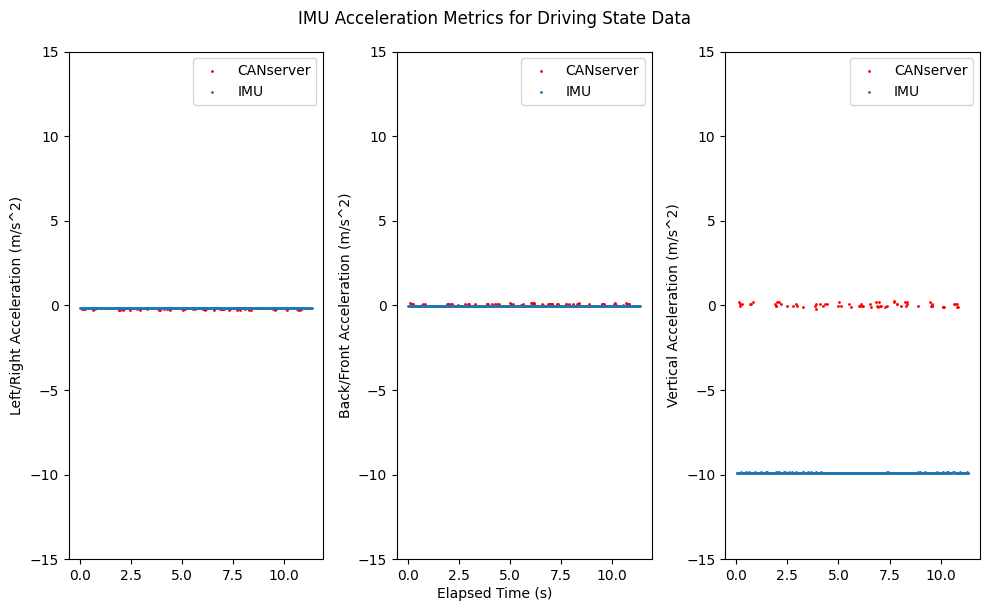

-0.01639166327940634


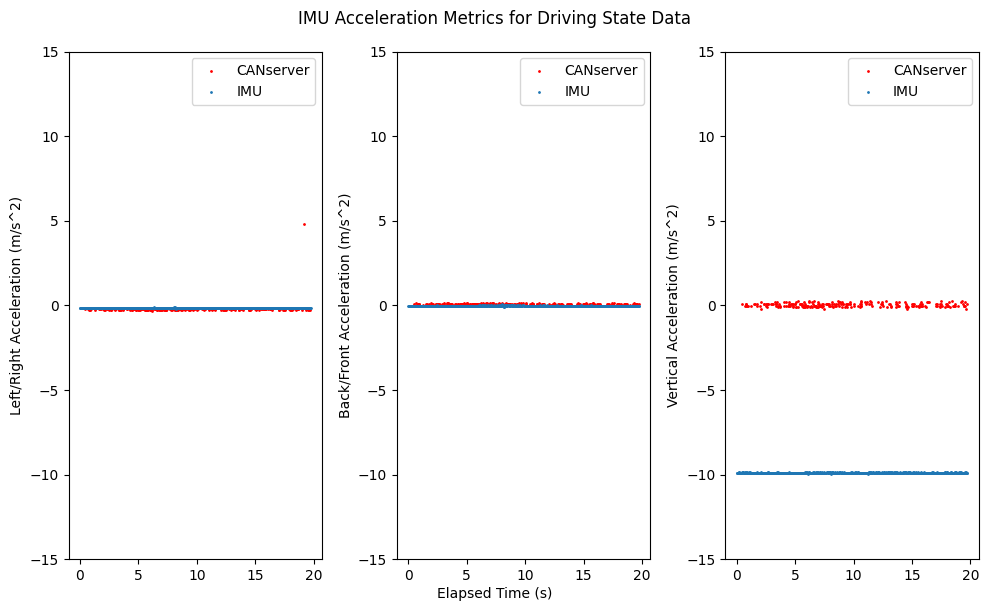

-0.017088501676175618


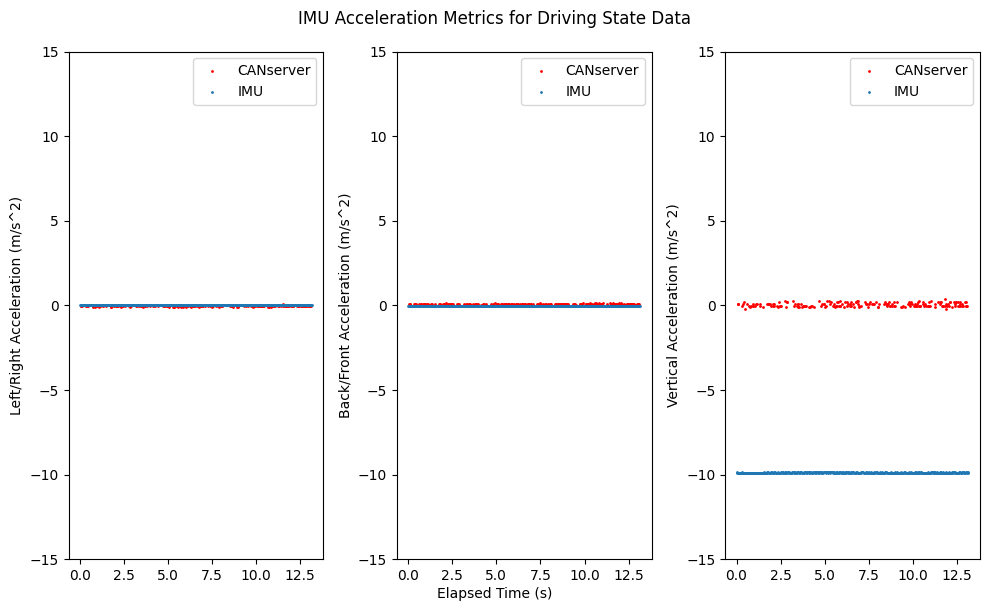

-0.017687111321175605


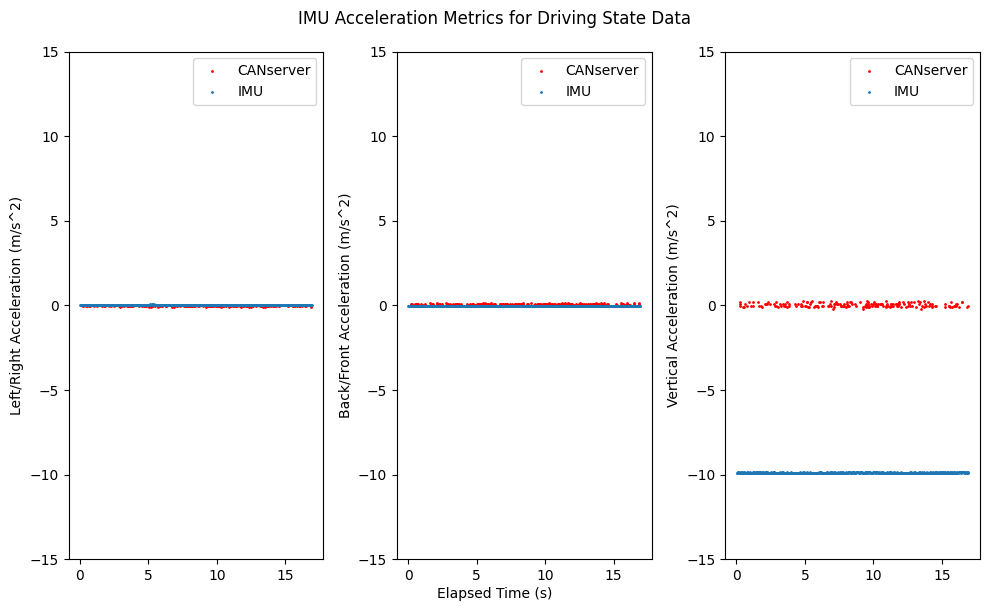

In [14]:
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['stationary_state'])):
    dr_start_time = event_dict['stationary_state'][state_num]['start']
    dr_end_time = event_dict['stationary_state'][state_num]['end']

    dr_motion = imu_df[(imu_df['correct_timestamp'] >= dr_start_time) 
                    & (imu_df['correct_timestamp'] <= dr_end_time)]
    can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                        & (can_df['timestamp'] <= dr_end_time)]

    count += 1
    # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
    # if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
    print(dr_motion['bf_acc(m/s^2)'].mean())
    plot_data.triaxis_plot(dr_motion, can_motion, dr_start_time)

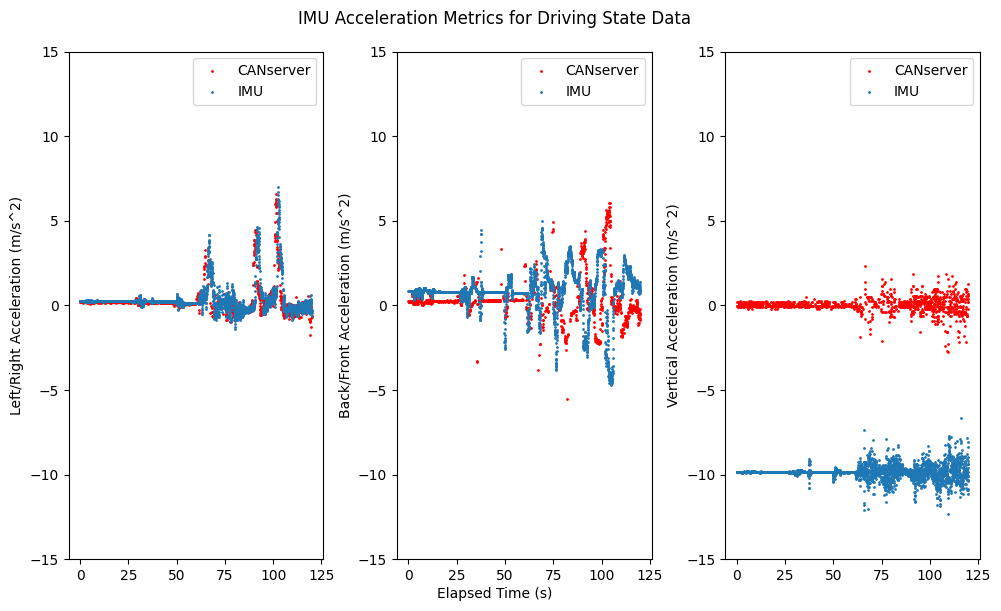

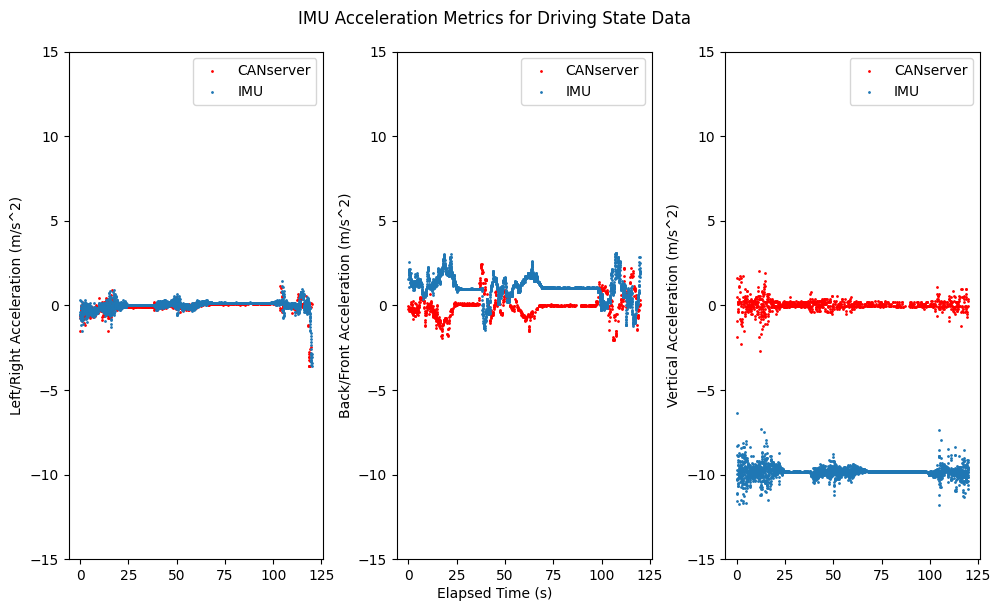

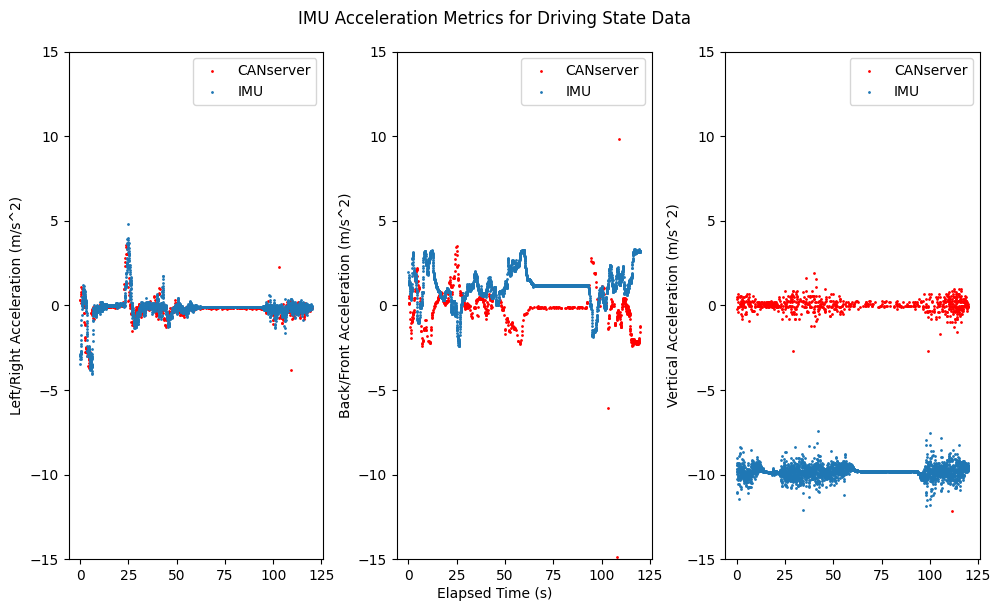

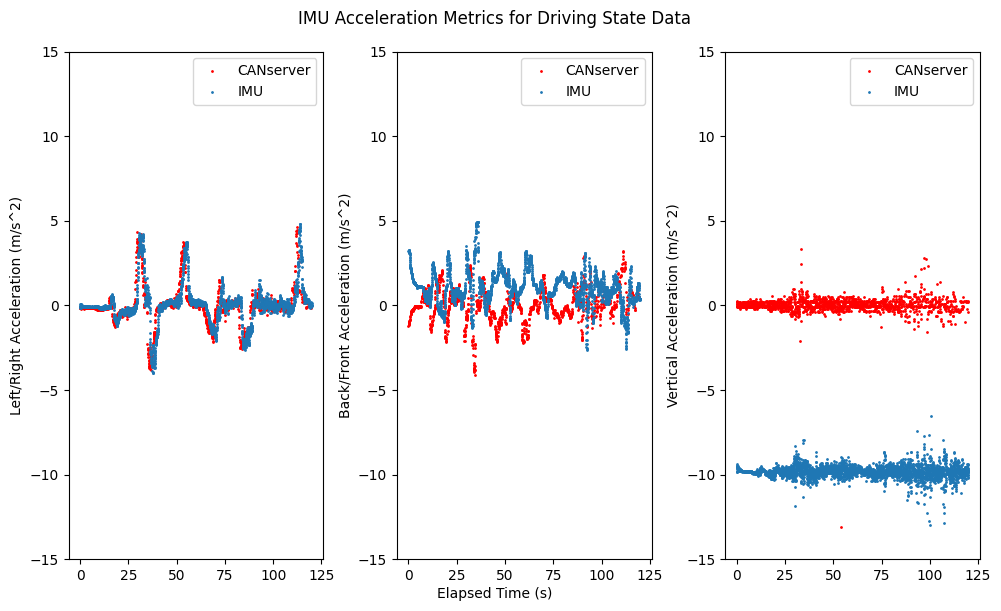

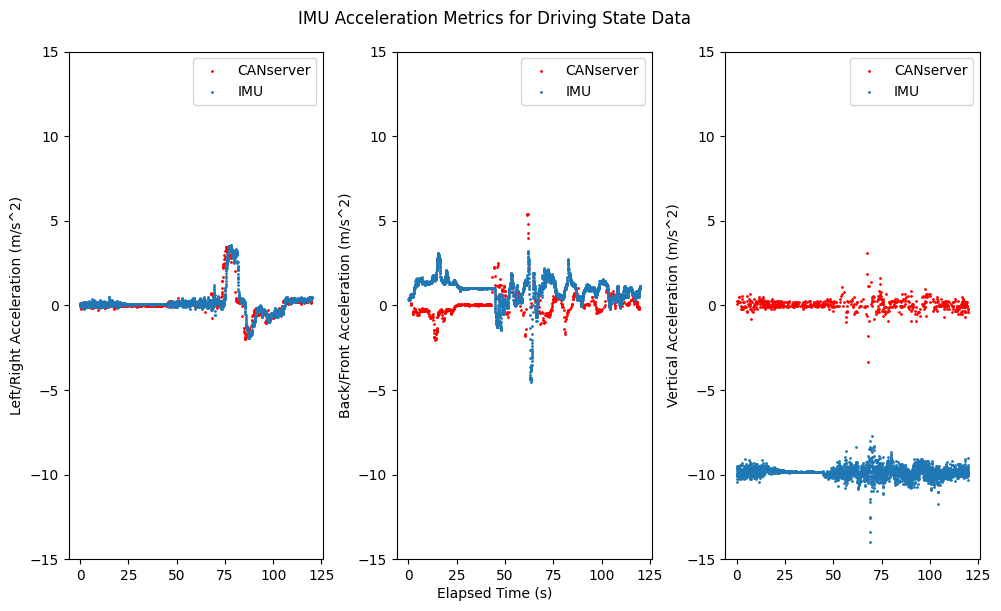

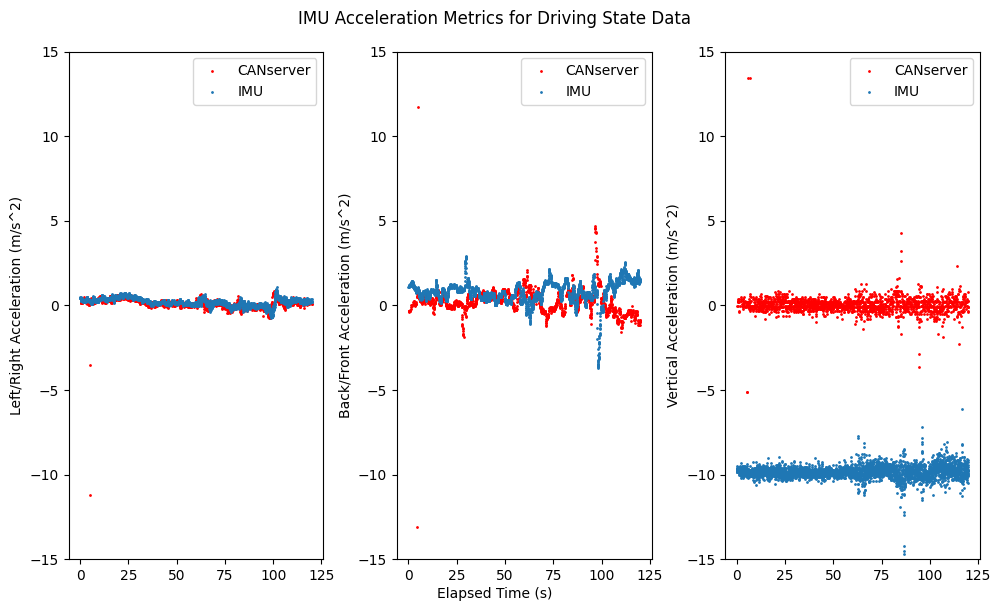

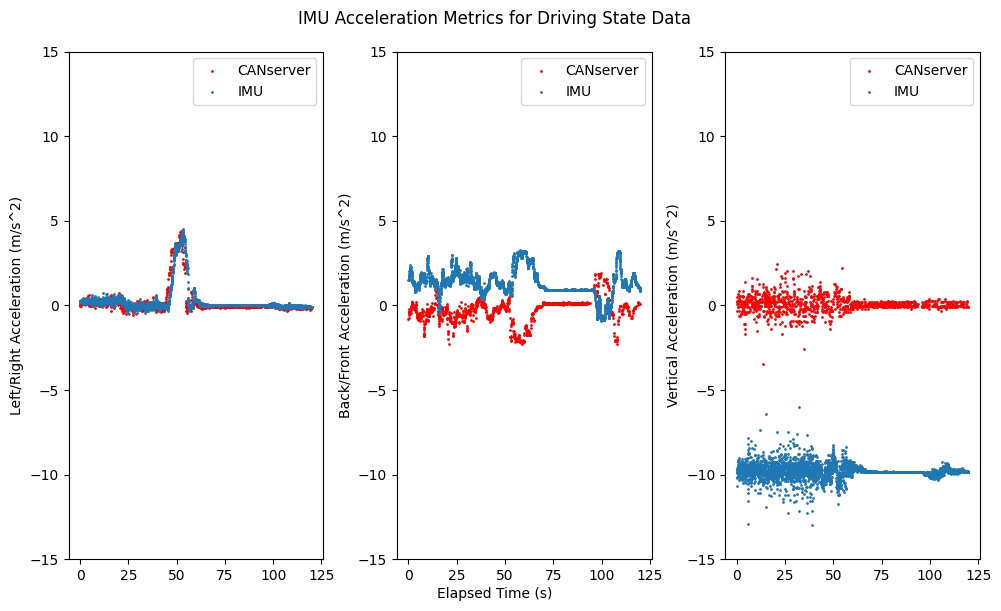

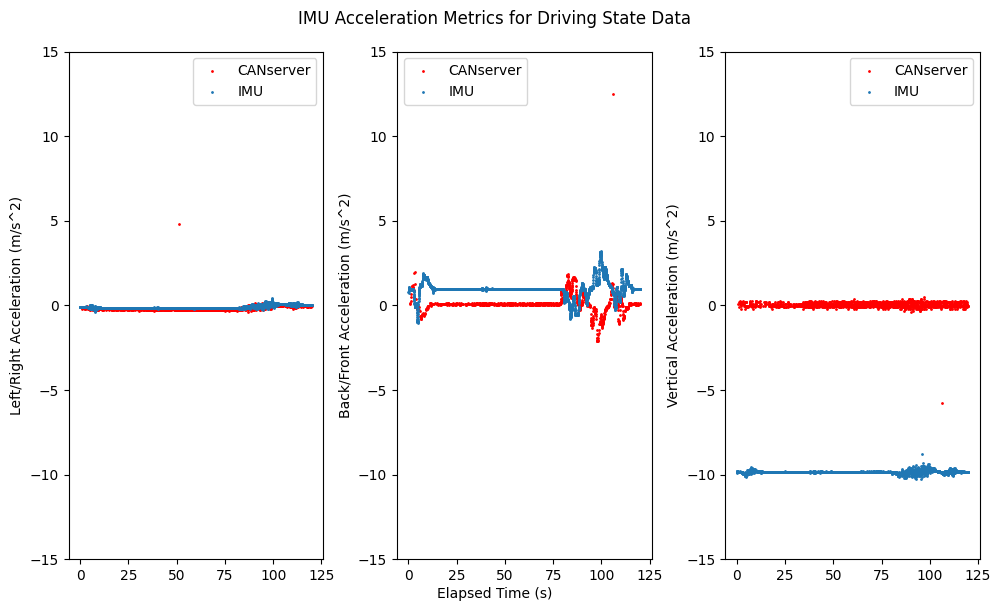

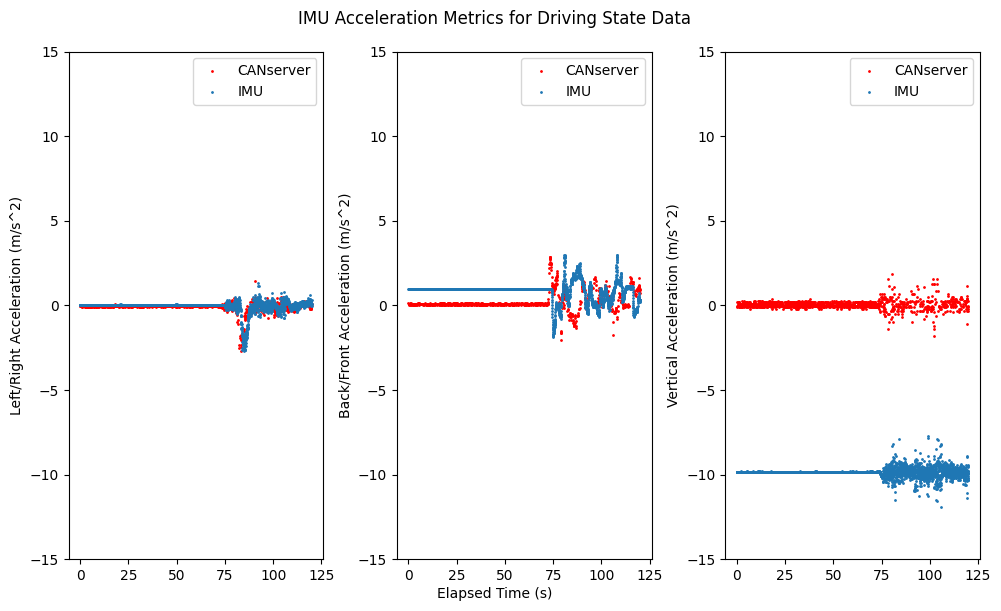

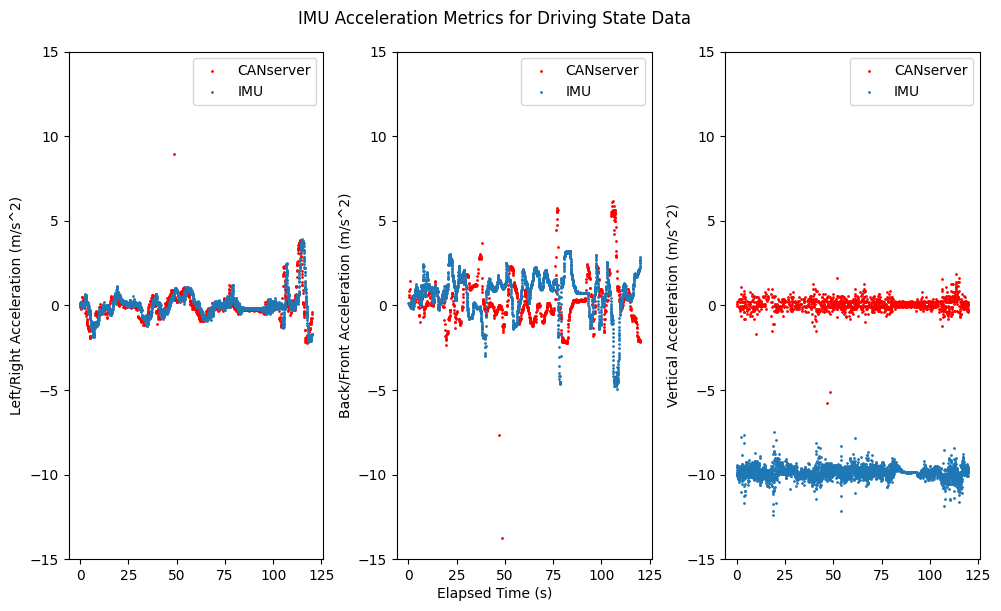

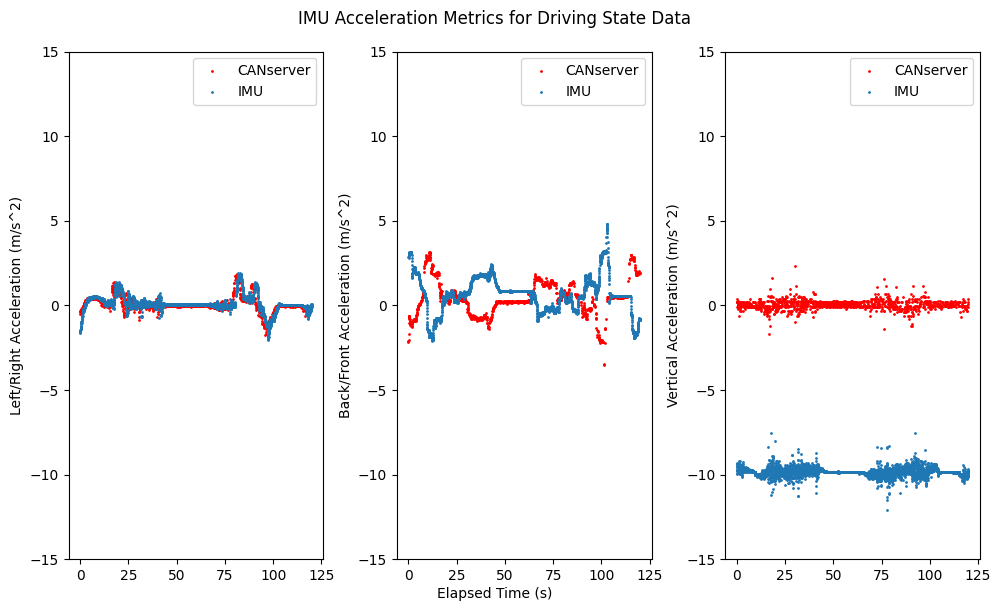

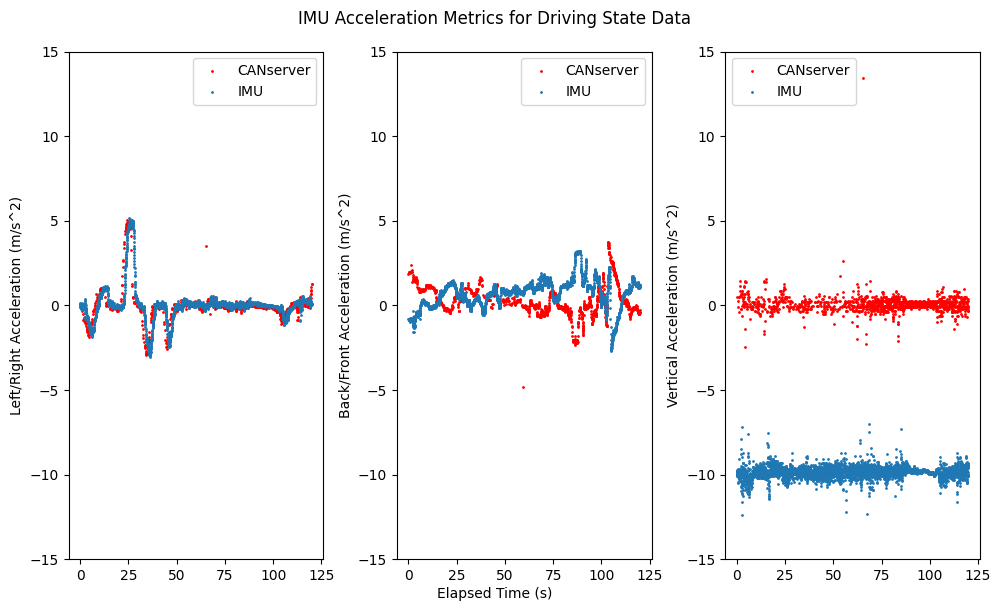

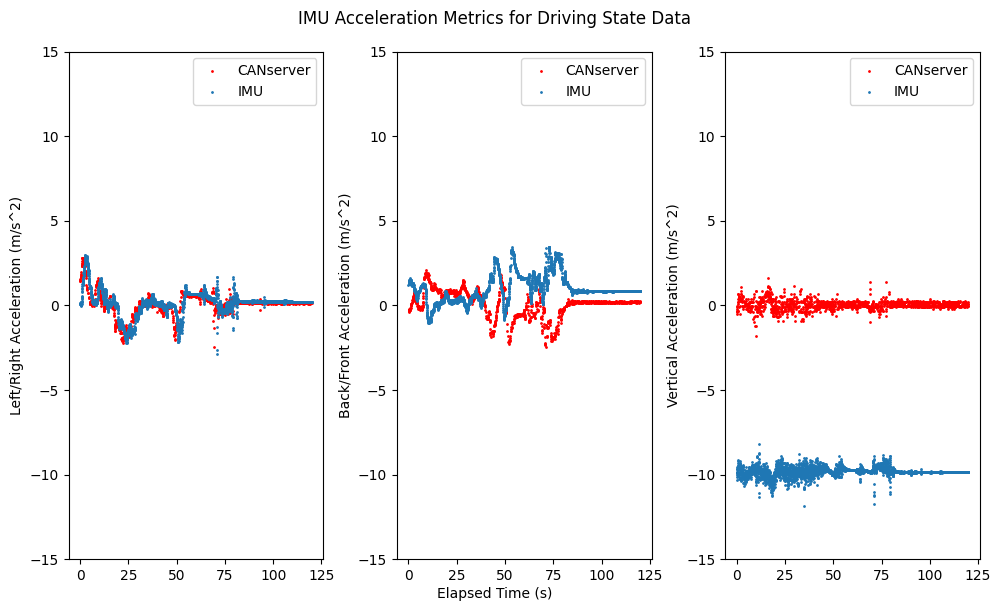

In [21]:
window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = imu_df[(imu_df['correct_timestamp'] >= dr_start_time) 
                        & (imu_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
        if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
            plot_data.triaxis_plot(dr_motion, can_motion, dr_start_time - window)